# Simple Feedforward Example

In [1]:
# Crap to prevent me from messing the code up for Python 3 people
from __future__ import division
from __future__ import print_function

# Regular Python Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import datasets # Some nice datasets to use

%matplotlib inline

# Torch imports
import torch
from torch.autograd import Variable, Function
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as pytorch_utils


## Define the Neural Network Architecture

In [2]:
class FeedForwardNN(nn.Module):
    """
    Simple fully connected, feedforward network.
    This should be ready to go for regression, 
    but for classification an additional softmax will need to be added on top.
    
    Parameters
    ----------
    layer_sizes : iterable of ints
        the size of each layer
    nonlinearity : class
        Type of nonlinearity to us, e.g. "nn.ReLU" or "nn.Tanh".
        This does NOT an initialized object, i.e. this
        argument does NOT an input of the form "nn.Relu()".
    """
    def __init__(self,  layer_sizes, nonlinearity=None):
        super(FeedForwardNN, self).__init__() # Python class stuff

        if nonlinearity is None: # Set the default nonlinearity.
            nonlinearity = nn.ReLU

        # Build the layers
        nlayers = len(layer_sizes)
        self.layers = []
        for i in range(nlayers - 1):
            linear = nn.Linear(layer_sizes[i], layer_sizes[i+1]) 
            self.layers.append(linear)
            self.layers.append(nonlinearity())
        
        # Put it together to make a neural network using nn.Sequential
        self.feed_forward = nn.Sequential(*self.layers)

    def forward(self, x):
        # Encode, then decode the network.
        x = self.feed_forward(x)
        return x
 

## Set Parameters

In [3]:
# Neural Network Parameters
hidden_layer_sizes = [5]  # Number of hidden layers to use.  More can be added by adding to this list.
nonlinearity = nn.LeakyReLU  # Nonlinear function to use.

# Training parameters
train_frac = 0.7  # Fraction of training points to use
epochs = 2000  # Number of passes to do over the dataset..
b_size = 32  # Number of datapoints to use in each step of the dynamics
learning_rate = 0.01  # Learning rate (step-size for optimizer.)
print_frequency = 100  # How often to print the loss.

## Prep the  Data

#### Load the iris dataset

In [4]:
iris_dataset = datasets.load_iris()
X = iris_dataset.data
y = iris_dataset.target
N, n_input = X.shape # Number of points, number of input dimensions 
n_classes = np.max(y) + 1 # Number of classes

#### Do a test-train split.  

In [5]:
N_train = int(train_frac * N)
indices = np.arange(N)
np.random.shuffle(indices)
train_ndxs = indices[:N_train]
test_ndxs = indices[N_train:]
X_train = X[train_ndxs]
y_train = y[train_ndxs]
X_test = X[test_ndxs]
y_test =y[test_ndxs]

#### Move everything into pytorch data loaders

In [6]:
# Typecast to pytorch tensors.
X_train_var = torch.from_numpy(X_train).float()
y_train_var = torch.from_numpy(y_train).long()
X_test_var = torch.from_numpy(X_test).float()
y_test_var = torch.from_numpy(y_test).long()

# Construct Tensor Datasets.  This is bundles a collection of tensor together for easy indexing
# The i'th element gives the i'th datapoint.
data_train = pytorch_utils.TensorDataset(X_train_var, y_train_var)
data_test = pytorch_utils.TensorDataset(X_test_var, y_test_var)

# This is an iterable we can iterate over to get a batches of data.  
train_loader = pytorch_utils.DataLoader(data_train, batch_size=b_size, shuffle=True)

## Train the network

#### Initialize the Neural Network

In [7]:
layer_sizes = [n_input] + hidden_layer_sizes + [n_classes]
model = FeedForwardNN(layer_sizes, nonlinearity)
normalizing_layer = nn.LogSoftmax() # We need a softmax on top of FeedForwardNN because we are doing classification.

#### Initialize Loss

In [8]:
loss_fxn = nn.NLLLoss()

#### Initialize the Optimizer

In [9]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_train = []

In [10]:
for epoch in range(epochs):
    epoch_loss = []
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # Cleans out any old gradient info.

        # Typecast to Variable, the datatype used for backprop
        X_i = Variable(data[0], requires_grad=True)
        y_i = Variable(data[1], requires_grad=False)
        
        # Run the model forward
        Y_i = model(X_i)
        Y_i = normalizing_layer(Y_i) # Not all the computation needs to happen inside the net object!
        
        # Evaluate loss and do backprop.
        loss = loss_fxn(Y_i, y_i)
        loss.backward()
        
        # Run the optimizer.
        optimizer.step()  
        loss_train.append(loss)
        epoch_loss.append(loss)
    avg_epoch_loss = sum(epoch_loss) / len(epoch_loss)

    if epoch % print_frequency == 0:
        print('Epoch: %d, Train Loss: %.6f' % (epoch, avg_epoch_loss))

/home/erik/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch: 0, Train Loss: 1.107685
Epoch: 100, Train Loss: 0.079020
Epoch: 200, Train Loss: 0.048919
Epoch: 300, Train Loss: 0.046716
Epoch: 400, Train Loss: 0.037431
Epoch: 500, Train Loss: 0.034458
Epoch: 600, Train Loss: 0.030033
Epoch: 700, Train Loss: 0.040404
Epoch: 800, Train Loss: 0.063405
Epoch: 900, Train Loss: 0.027431
Epoch: 1000, Train Loss: 0.026912
Epoch: 1100, Train Loss: 0.064934
Epoch: 1200, Train Loss: 0.026601
Epoch: 1300, Train Loss: 0.031744
Epoch: 1400, Train Loss: 0.030774
Epoch: 1500, Train Loss: 0.028664
Epoch: 1600, Train Loss: 0.029104
Epoch: 1700, Train Loss: 0.061948
Epoch: 1800, Train Loss: 0.024158
Epoch: 1900, Train Loss: 0.029046


## Plot the results

#### Get results for all datapoints in numpy

In [11]:
# Run all data through the network.
all_train_data = Variable(X_train_var)
Y_train_var = normalizing_layer(model(all_train_data))
all_test_data = Variable(X_test_var)
Y_test_var = normalizing_layer(model(all_test_data))

# Typecast back to numpy for plotting
Y_train = np.exp(Y_train_var.data.numpy())
Y_test = np.exp(Y_test_var.data.numpy())
nn_labels_train = np.argmax(np.exp(Y_train), axis=1)
nn_labels_test = np.argmax(np.exp(Y_test), axis=1)

/home/erik/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/erik/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """


#### Plot the results

Text(0,0.5,u'petal width (cm)')

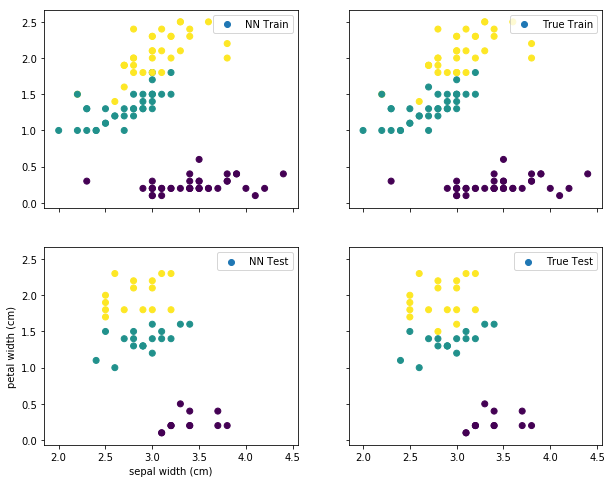

In [13]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axes[0, 0].scatter(X_train[:,1], X_train[:,3], c=nn_labels_train, label='NN Train')
axes[0, 1].scatter(X_train[:,1], X_train[:,3], c=y_train, label='True Train')
axes[1 ,0].scatter(X_test[:,1], X_test[:,3], c=nn_labels_test, label='NN Test')
axes[1, 1].scatter(X_test[:,1], X_test[:,3], c=y_test, label='True Test')

axf = np.array(axes).ravel()
for ax in axf:
    ax.legend(loc='upper right')

axes[1, 0].set_xlabel(iris_dataset.feature_names[1])
axes[1, 0].set_ylabel(iris_dataset.feature_names[3])